In [6]:
import numpy as np
import pandas as pd 
from math import sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (14,7)

data = pd.read_csv("./heart.csv")
discrete = ["sex","cp", "fbs","restecg","exang","slope", "ca", "thal"]
continuse = ["trestbps","age","oldpeak","thalach","chol"]


data.sample(frac=1).reset_index(drop=True) 
data_train, data_test = train_test_split(data, test_size=0.30)
data_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
211,67,1,0,100,299,0,0,125,1,0.9,1,2,2,0
89,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
711,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0
24,42,0,2,120,209,0,1,173,0,0.0,1,0,2,1
188,63,1,0,130,254,0,0,147,0,1.4,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0
282,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
227,44,0,2,118,242,0,1,149,0,0.3,1,1,2,1
102,54,1,1,108,309,0,1,156,0,0.0,2,0,3,1


In [7]:

data_train_0 = data_train.loc[data_train['target'] == 0]
data_train_0 =data_train_0[continuse]   
means0 = []
for feature in continuse:
    means0.append(data_train_0[feature].mean())
covs0 = np.array(data_train_0.cov()) 


data_train_1 = data_train.loc[data_train['target'] == 1]
data_train_1 =data_train_1[continuse]   
means1 = []
for feature in continuse:
    means1.append(data_train_1[feature].mean())
covs1 = np.array(data_train_1.cov()) 



In [8]:
def MulVarNormal(x,mean,covariance,d):
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

def ProbabilityCalculate(x,data_temp,target):
    Prob = data_temp['target'].value_counts()[target] / sum(list((data_temp['target'].value_counts()))) 
    
    data_temp = data_temp.loc[data_temp['target'] == target]
    
    
    for feature in discrete :
        Prob *=  data_temp[feature].value_counts()[x[feature]]/ sum(list((data_temp[feature].value_counts()))) 
        
        
    x_conti = [x["trestbps"],x["age"],x["oldpeak"],x["thalach"],x["chol"]]
    if target == 0 :
        p = MulVarNormal(x_conti,np.array(means0),covs0,len(continuse))
        if p == 0 :
           return Prob 
        Prob *= p
    else :
        p = MulVarNormal(x_conti,np.array(means1),covs1,len(continuse))
        if p == 0 :
           return Prob 
        Prob *= p
        
    
    
    return Prob
        
    

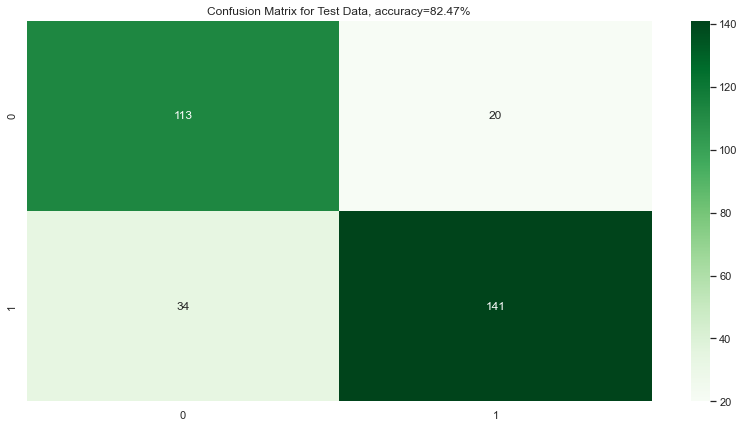

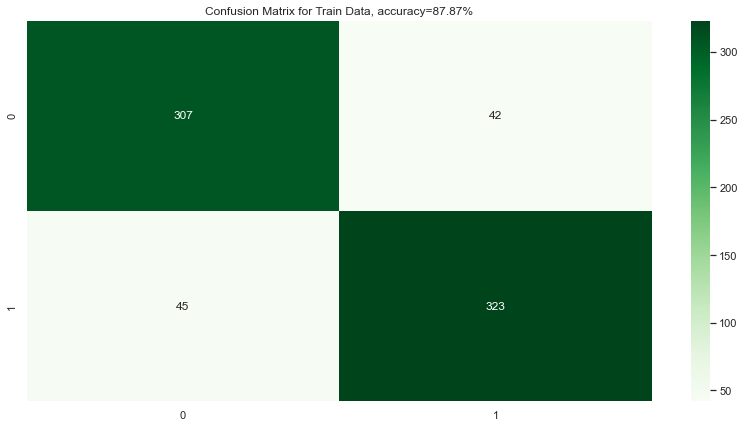

0 0


In [9]:
confusion_matrix_test = []
confusion_matrix_train = []

for _ in range(2):
    confusion_matrix_test.append([int(0),int(0)])
    confusion_matrix_train.append([int(0),int(0)])

EqualTrain = 0
EqualTest = 0
for test in data_test.to_dict('records') :    
    p_0 = ProbabilityCalculate(test,data_train,0)
    p_1 = ProbabilityCalculate(test,data_train,1)
    predict = 1
    if p_0 > p_1 :
        predict = 0
    if p_0 == p_1 :
        EqualTest +=1
    else:    
        confusion_matrix_test[predict][test["target"]] += 1
    
for test in data_train.to_dict('records') :    
    p_0 = ProbabilityCalculate(test,data_train,0)
    p_1 = ProbabilityCalculate(test,data_train,1)
    predict = 1
    if p_0 > p_1 :
        predict = 0
    
    if p_0 == p_1 :
        EqualTrain +=1        
    else:    
        confusion_matrix_train[predict][test["target"]] += 1

acc = ((confusion_matrix_test[0][0]+confusion_matrix_test[1][1])/data_test.shape[0])*100
acc = round(acc,2)
sns.heatmap(confusion_matrix_test ,annot=True, cmap='Greens', fmt='g').set_title("Confusion Matrix for Test Data, accuracy={0}%".format(acc))
plt.show()

acc = ((confusion_matrix_train[0][0]+confusion_matrix_train[1][1])/data_train.shape[0])*100
acc = round(acc,2)
sns.heatmap(confusion_matrix_train ,annot=True, cmap='Greens', fmt='g').set_title("Confusion Matrix for Train Data, accuracy={0}%".format(acc))
plt.show()
print(EqualTest,EqualTrain)